In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir(os.getcwd()+'/drive/MyDrive/Cassava-Leaf-Disease-Classification')

In [9]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=5daace07c7f1375ec05b063de0d01d5daef79a9bab1260e4377c5826ab0fe857
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

 90% 5.16G/5.76G [01:13<00:06, 103MB/s] 

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('cassava-leaf-disease-classification.zip', 'r')
zip_ref.extractall('cassava-leaf-disease-classification')
zip_ref.close()

In [ ]:
WORK_DIR = os.getcwd()+'/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'test_images',
 'test_tfrecords',
 'train.csv',
 'train_images',
 'train_tfrecords']

In [ ]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [ ]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [ ]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


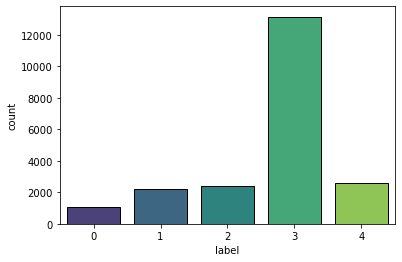

In [ ]:
sns.countplot(train_labels.label, edgecolor = 'black',
              palette = sns.color_palette("viridis", 5))
plt.show()

We have imbalanced data with domination of third class: "Cassava Mosaic Disease (CMD)"

### Some photos of dominant class (with CMD)

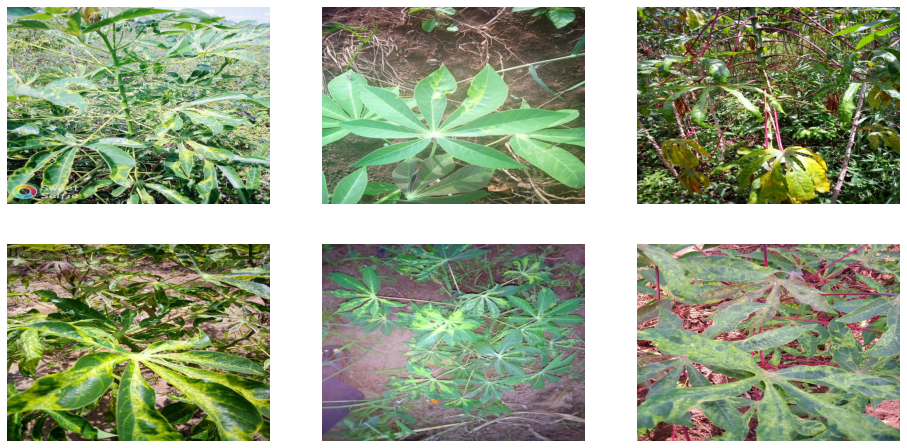

In [ ]:
sample = train_labels[train_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

### Some photos of healthy plants

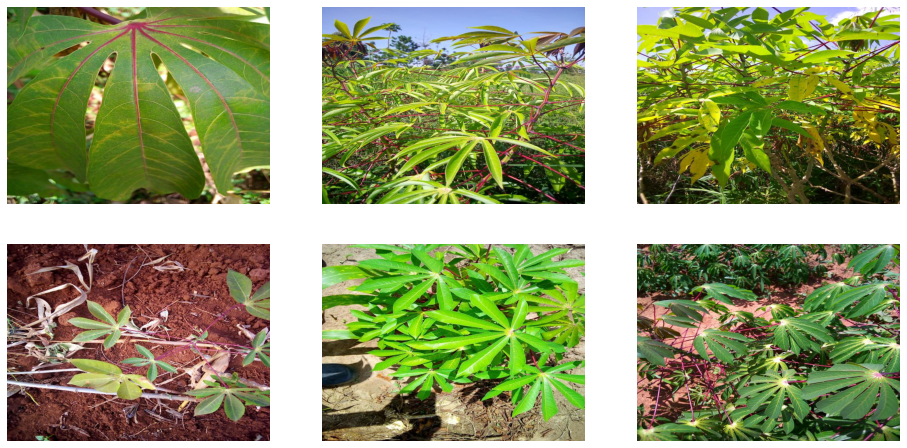

In [ ]:
sample = train_labels[train_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

## The baseline level of accuracy

In [ ]:
y_pred = [3] * len(train_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, train_labels.label))

The baseline accuracy: 0.615


Our future model must have accuracy better than 0.615.

## Modeling

In [ ]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 224

In [ ]:
train_labels.label = train_labels.label.astype('str')

train_generator = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


Based on other submittals, I will try EfficientNetB0. It will be my baseline NN for future improvements.

In [ ]:
def create_model():
    model = models.Sequential()

    model.add(EfficientNetB0(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))
    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20
 12/267 [>.............................] - ETA: 1:03:04 - loss: 1.0842 - acc: 0.6159

KeyboardInterrupt: 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [ ]:
model.save('./baseline_model.h5')

In [ ]:
ss = pd.read_csv(os.path.join(WORK_DIR, "sample_submission.csv"))
ss

In [ ]:
preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(WORK_DIR,  "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

ss['label'] = preds
ss

In [ ]:
ss.to_csv('submission.csv', index = False)